In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import signal
from scipy.fftpack import dct, idct, fft, ifft

import MEArec as mr
import MEAutility
import spikeinterface as si
import spikeinterface.sorters as ss
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
import spikeinterface.sorters as ssort
import spikeinterface.widgets as sw

from sklearn.ensemble import IsolationForest

It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.


In [2]:
recording60, gt60 = se.read_mearec('data/recgen60-03-file.h5')

In [3]:
sv = recording60.get_traces()
ns = recording60.get_num_samples()
nch = recording60.get_num_channels()
fs = recording60.get_sampling_frequency()
nseg = recording60.get_num_segments()
probe = recording60.get_probe()

In [4]:
rec = pd.DataFrame(sv[:10000,:2])
rec.head()

,0,1
0,4.918129,25.683023
1,-20.072182,-10.744051
2,-4.617264,-23.724701
3,-5.322465,-57.930740
4,-20.636200,-36.307953


In [6]:
clf = IsolationForest( n_estimators=100, random_state=0, contamination =.1).fit(rec)
prediction = clf.predict(rec)
abn_ind = np.where(prediction<0)

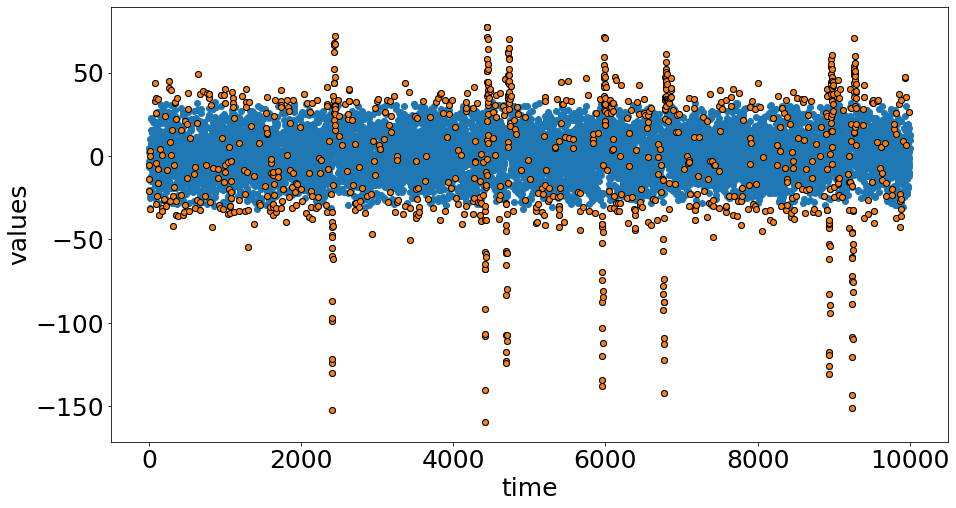

In [7]:
plt.figure(figsize=(15,8))
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25)
plt.ylabel('values', fontsize=25)
plt.xlabel('time', fontsize=25)
plt.scatter(rec.index, rec[0])
plt.scatter(abn_ind[0], rec[0][abn_ind[0]], edgecolor = '0')

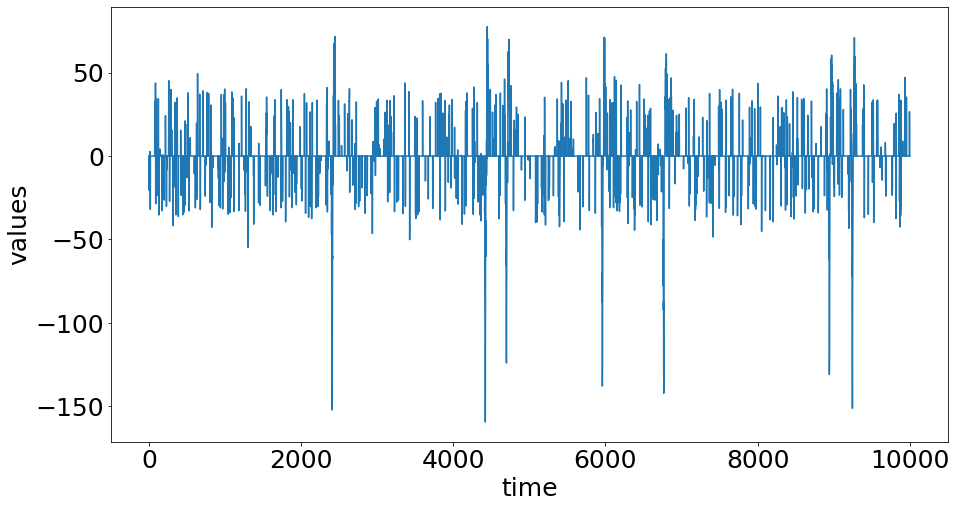

In [8]:
plt.figure(figsize=(15,8))
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25)
plt.ylabel('values', fontsize=25)
plt.xlabel('time', fontsize=25)
s0 = np.ma.masked_where( prediction>0, rec[0])
y0 = np.ma.filled(s0.astype(float), 0.0)
plt.plot(y0)

In [10]:
def make_sparse(x,t):
    l = x.reshape(-1)
    p = np.argsort(np.abs(l))[-t]
    s = np.ma.masked_where(np.abs(x) < np.abs(l[p]), x)
    y = np.ma.filled(s.astype(float), 0.0)
    return y  

In [11]:
# X should have the shape of (ns, nch)
def outlier_detection(x, p ):
    ns, nch = x.shape
    clf = IsolationForest( n_estimators=100, random_state=0, contamination =p).fit(x)
    prediction = clf.predict(x)
    y= np.zeros((ns, nch))
    for i in range(nch):
        s = np.ma.masked_where( prediction>0, x[:,i])
        y[:,i] = np.ma.filled(s.astype(float), 0.0)
    return y

In [12]:
def percent(m1, m2, m3, nch, ns, w_length):
    print('%3f percent of sample in total when peack %3f coefficients per sample'%(100*m1*nch/(nch*ns),m1))
    print('%3f percent of sample in total when peack %3f coefficients per channel'%(100*m2*ns/(nch*ns),m2))
    print('%3f percent of sample in total when peack %3f coefficients per frame'%(100*m3*(2*ns/w_length) / (nch*ns) ,m3))

In [12]:
sv_t = outlier_detection(sv, .3)

In [13]:
p_nonzero = np.nonzero(sv_t)[0].shape[0] / (nch*ns)
print('percentage of servived samples', p_nonzero*100 )

percentage of servived samples 30.0


In [14]:
recording60_t = se.NumpyRecording(sv_t, sampling_frequency=fs)
probe = recording60.get_probe() # get the probe from orginal recording
recording60_t = recording60_t.set_probe(probe)
sorting_IC60_t = ss.run_ironclust(recording=recording60_t, output_folder='tmp_IC60_t')
cmp_gt_IC60_t = sc.compare_sorter_to_ground_truth(gt60, sorting_IC60_t, exhaustive_gt=True)
perf_IC60_t = cmp_gt_IC60_t.get_performance()

RUNNING SHELL SCRIPT: tmp_IC60_t/run_ironclust.sh


It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configura

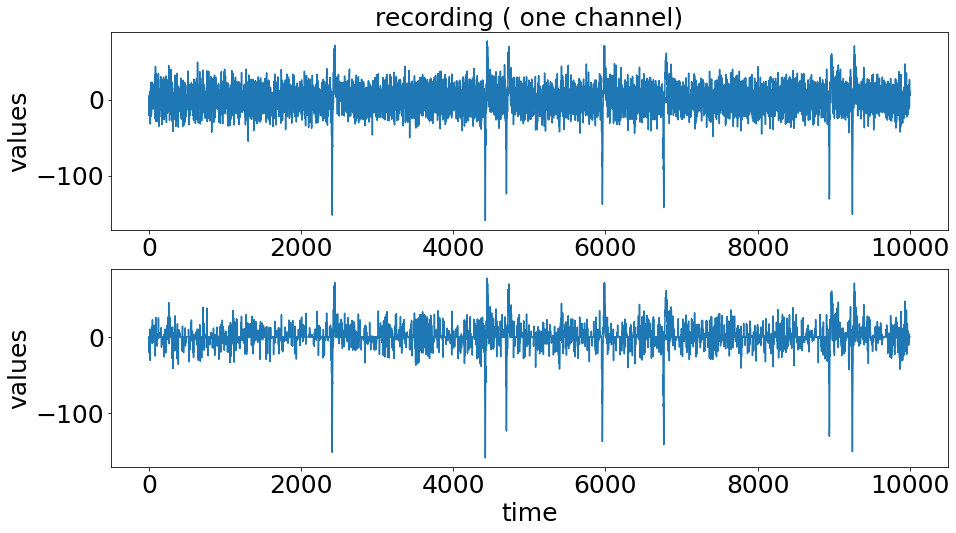

In [17]:
plt.figure(figsize=(15,8))
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25)
plt.subplot(2,1,1)
plt.ylabel('values', fontsize=25)
plt.title('recording ( one channel)', fontsize=25)
plt.plot(sv[:10000,0])
plt.subplot(2,1,2)
plt.xlabel('time', fontsize=25)
plt.ylabel('values', fontsize=25)
plt.plot(sv_t[:10000,0])

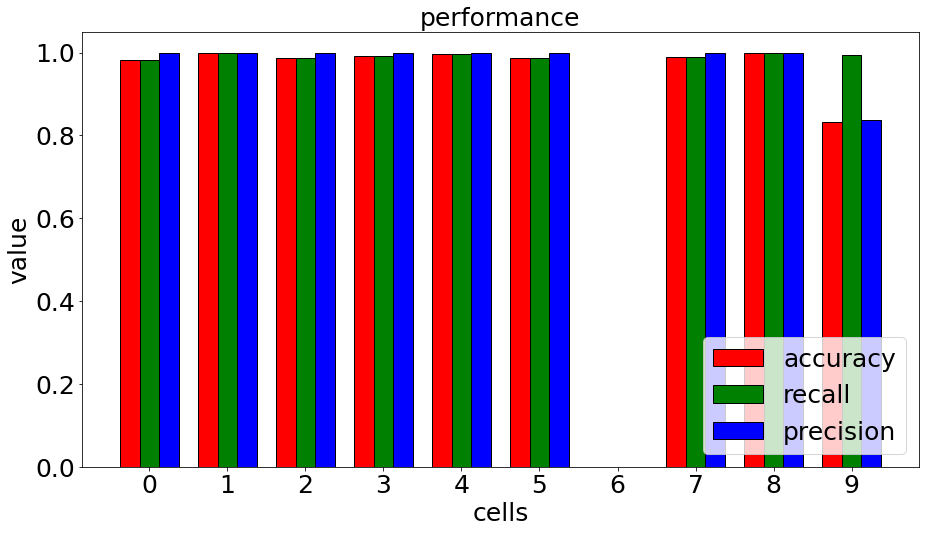

In [18]:
s = perf_IC60_t
n_cell = 10
r = np.arange(n_cell)
width = 0.25
plt.figure(figsize=(15,8))
plt.bar(r, s['accuracy'], color = 'r',
        width = width, edgecolor = 'black',
        label='accuracy')
plt.bar(r + width, s['recall'], color = 'g',
        width = width, edgecolor = 'black',
        label='recall')
plt.bar(r + 2*width, s['precision'], color = 'b',
        width = width, edgecolor = 'black',
        label= 'precision')

plt.xlabel("cells", fontsize = 25)
plt.ylabel("value", fontsize = 25)
plt.title("performance", fontsize = 25)

plt.xticks(r + width,[str(i) for i in range(n_cell)])
plt.legend(loc = "lower right", fontsize=25)
  
plt.show()

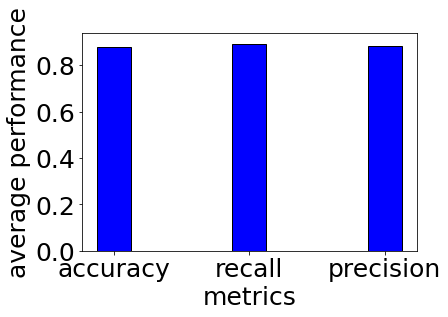

In [19]:
n = ['accuracy', 'recall', 'precision']
plt.bar(n, s.mean().iloc[:3], color = 'b',
        width = width, edgecolor = 'black',
        label='average ')
plt.xlabel("metrics", fontsize = 25)
plt.ylabel("average performance", fontsize = 25)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

plt.show()

In [22]:
def percent(m1, m2, m3, nch, ns, w_length):
    print('%3f percent of sample in total when peack %3f coefficients per sample'%(100*m1*nch/(nch*ns),m1))
    print('%3f percent of sample in total when peack %3f coefficients per channel'%(100*m2*ns/(nch*ns),m2))
    print('%3f percent of sample in total when peack %3f coefficients per frame'%(100*m3*(2*ns/w_length) / (nch*ns) ,m3)) 

In [21]:
w_length = 10000
bc = scp.signal.windows.boxcar(w_length, sym=True)
f, t, Zxx = scp.signal.stft(sv_t.T, fs=fs, window=bc, nperseg=w_length)

In [24]:
ms = 19200
mch = 1
mf = 5000
percent(ms, mch, mf, nch, ns, w_length)

1.000000 percent of sample in total when peack 19200.000000 coefficients per sample
1.000000 percent of sample in total when peack 1.000000 coefficients per channel
1.000000 percent of sample in total when peack 5000.000000 coefficients per frame


In [25]:
Zxx_t = []
for i in range(Zxx.shape[-1]):
    vfft = fft(Zxx[:,:,i], axis=0) 
    ivfft = ifft(make_sparse(vfft.real, mf) , axis=0) 
    Zxx_t.append(ivfft)
Zxx_t = np.swapaxes(Zxx_t,1,0)
Zxx_t = np.swapaxes(Zxx_t,1,2)
_,sv3d_t = scp.signal.istft(Zxx_t, fs=fs, window=bc, nperseg=w_length)

In [27]:
recording60_t = se.NumpyRecording(sv3d_t.T, sampling_frequency=fs)
probe = recording60.get_probe() # get the probe from orginal recording
recording60_t = recording60_t.set_probe(probe)
sorting_IC60_t = ss.run_ironclust(recording=recording60_t, output_folder='tmp_IC60_t')
cmp_gt_IC60_t = sc.compare_sorter_to_ground_truth(gt60, sorting_IC60_t, exhaustive_gt=True)
perf_IC60_t = cmp_gt_IC60_t.get_performance()

RUNNING SHELL SCRIPT: tmp_IC60_t/run_ironclust.sh


It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configura

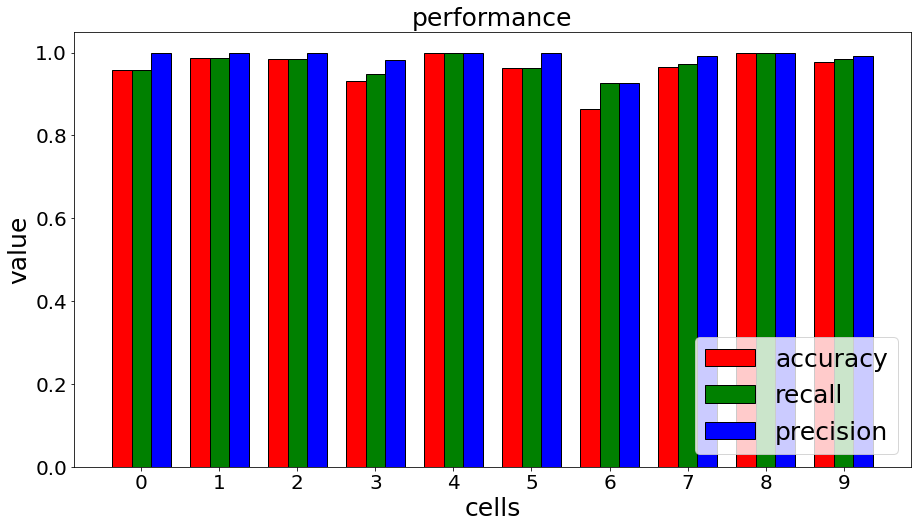

In [28]:
s = perf_IC60_t
n_cell = 10
r = np.arange(n_cell)
width = 0.25
plt.figure(figsize=(15,8))
plt.bar(r, s['accuracy'], color = 'r',
        width = width, edgecolor = 'black',
        label='accuracy')
plt.bar(r + width, s['recall'], color = 'g',
        width = width, edgecolor = 'black',
        label='recall')
plt.bar(r + 2*width, s['precision'], color = 'b',
        width = width, edgecolor = 'black',
        label= 'precision')

plt.xlabel("cells", fontsize = 25)
plt.ylabel("value", fontsize = 25)
plt.title("performance", fontsize = 25)

plt.xticks(r + width,[str(i) for i in range(n_cell)])
plt.legend(loc = "lower right", fontsize=25)
  
plt.show()

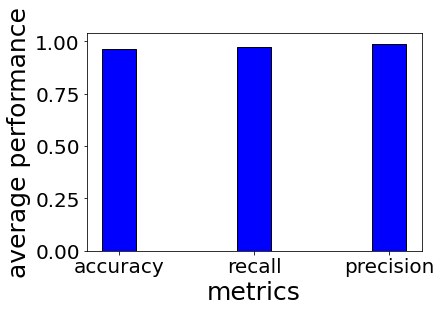

In [29]:
n = ['accuracy', 'recall', 'precision']
plt.bar(n, s.mean().iloc[:3], color = 'b',
        width = width, edgecolor = 'black',
        label='average ')
plt.xlabel("metrics", fontsize = 25)
plt.ylabel("average performance", fontsize = 25)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

plt.show()

## End of outlier detection 

## Build a recording of 2 minutes, use the first one minuts to build a model and build a decision for the next 1 minutes. Then, test how the results are promissing!
## choose the outlier detection as the predictive model.

In [22]:
templates_params = mr.get_default_templates_params()
cell_models_folder = mr.get_default_cell_models_folder()
templates_params['probe'] = 'SqMEA-10-15'
templates_params['n'] = 5
templates_params['seed'] = 0
tempgen = mr.gen_templates(cell_models_folder=cell_models_folder, params=templates_params, parallel=True, verbose=True)
mr.save_template_generator(tempgen, 'data/tempgen02-file.h5')

Setting n_jobs to 32 CPUs
Running with 32 jobs
Intracellular simulation: /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_DBC_bAC217_1



Cell has already be simulated. Using stored membrane currents



Extracellular simulation: /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_DBC_bAC217_1
Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
template bAC217_L5_DBC_4765d943f4 exist already
Cell L5_DBC_bAC217_1 extracellular spikes to be simulated
Cell: L5_DBC_bAC217_1 Progress: [1/5]
Cell: L5_DBC_bAC217_1 Progress: [2/5]
Cell: L5_DBC_bAC217_1 Progress: [3/5]
Cell: L5_DBC_bAC217_1 Progress: [4/5]
Cell: L5_DBC_bAC217_1 Progress: [5/5]
Done generating EAPs for L5_DBC_bAC217_1
Intracellular simulation: /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_MC_bAC217_1



Cell has already be simulated. Using stored membrane currents



Extracellular simulation: /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_MC_bAC217_1
Setting temperature to 




Simulation time: 27.225387573242188




Saved  templates in data/tempgen02-file.h5 



In [23]:
recordings_params = mr.get_default_recordings_params()
recordings_params['spiketrains']['n_exc'] = 7
recordings_params['spiketrains']['n_inh'] = 3
recordings_params['spiketrains']['duration'] = 60
recordings_params['seeds']['spiketrains'] = 0
recordings_params['seeds']['templates'] = 1
recordings_params['seeds']['noise'] = 2
recordings_params['seeds']['convolution'] = 1

recgen60_120 = mr.gen_recordings(params=recordings_params, templates='data/tempgen02-file.h5')
mr.save_recording_generator(recgen60_120, 'data/recgen60_120-file.h5')

Spiketrains seed:  0
Noise Level  10
Templates selection seed:  1
Selecting cells
Padding template edges
Elapsed pad time: 0.4536886215209961
Creating time jittering
Elapsed jitter time: 1.1933214664459229
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  1
Electrode modulaton
Adding noise
Noise seed:  2
Filtering
Band-pass cutoff [ 300. 6000.] Hz
Elapsed time:  52.30441556870937
Deleted /tmp/tmpx8_tz0b3
Starting 10


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_STPC_cADpyr232_1 10/13


Exiting 10
Starting 6


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_MC_bAC217_1 6/13


Exiting 6
Starting 3


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_ChC_cACint209_1 3/13


Exiting 3
Starting 4


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_DBC_bAC217_1 4/13


Exiting 4
Starting 12


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_TTPC2_cADpyr232_1 12/13


Exiting 12
Starting 2


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L

In [24]:
recording60, gt60 = se.read_mearec('data/recgen60_120-file.h5')

In [25]:
sv = recording60.get_traces()
ns = recording60.get_num_samples()
nch = recording60.get_num_channels()
fs = recording60.get_sampling_frequency()
nseg = recording60.get_num_segments()
probe = recording60.get_probe()

### Recording 60s ot of 120s

In [26]:
recording60_t = se.NumpyRecording(sv, sampling_frequency=fs)
probe = recording60.get_probe() # get the probe from orginal recording
recording60_t = recording60_t.set_probe(probe)
sorting_IC60_t = ss.run_ironclust(recording=recording60_t, output_folder='tmp_IC60_t')
cmp_gt_IC60_t = sc.compare_sorter_to_ground_truth(gt60, sorting_IC60_t, exhaustive_gt=True)
perf_IC60_t = cmp_gt_IC60_t.get_performance()

RUNNING SHELL SCRIPT: tmp_IC60_t/run_ironclust.sh
Starting 6


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_MC_bAC217_1 6/13


Exiting 6
Starting 4


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_DBC_bAC217_1 4/13


Exiting 4
Starting 3


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_ChC_cACint209_1 3/13


Exiting 3
Starting 10


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_STPC_cADpyr232_1 10/13


Exiting 10
Starting 2


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_BTC_bAC217_1 2/13


Exiting 2
Starting 12


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_TTPC2_cADpyr232_1 12/13


Exiting 12
Starting 13


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_UTPC_cADpyr232_1 13/13


Exiting 13
Starting 5


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_LBC_bAC217_1 5/13


Exiting 5
Starting 11


 /home/eazizi/.config/mearec/1.7.2/cell_models/bbp/L5_TTPC1_cADpyr232_1 11/13


Exiting 11
Starting 8


 /home/eazizi/.config/mearec/1.7

It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configura

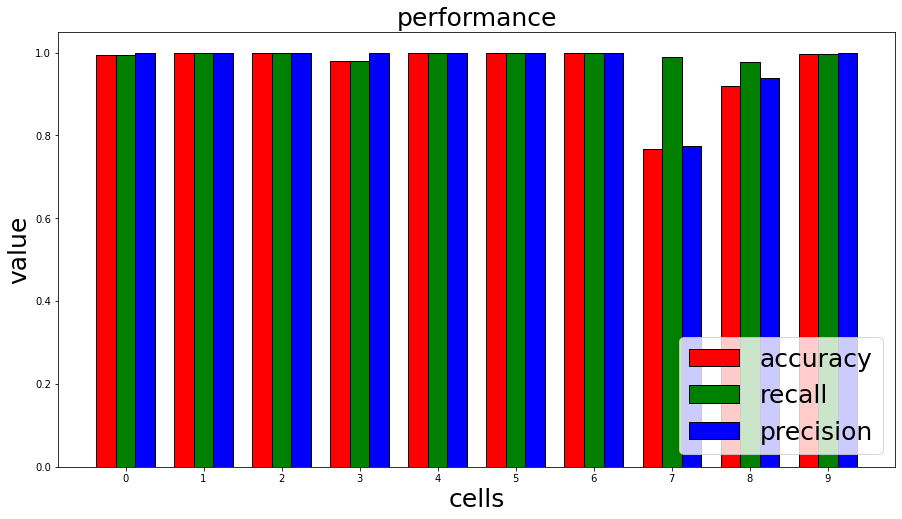

In [27]:
s = perf_IC60_t
n_cell = 10
r = np.arange(n_cell)
width = 0.25
plt.figure(figsize=(15,8))
plt.bar(r, s['accuracy'], color = 'r',
        width = width, edgecolor = 'black',
        label='accuracy')
plt.bar(r + width, s['recall'], color = 'g',
        width = width, edgecolor = 'black',
        label='recall')
plt.bar(r + 2*width, s['precision'], color = 'b',
        width = width, edgecolor = 'black',
        label= 'precision')

plt.xlabel("cells", fontsize = 25)
plt.ylabel("value", fontsize = 25)
plt.title("performance", fontsize = 25)

plt.xticks(r + width,[str(i) for i in range(n_cell)])
plt.legend(loc = "lower right", fontsize=25)
  
plt.show()

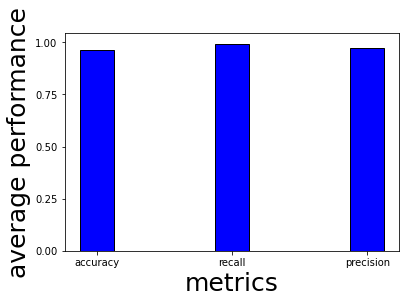

In [28]:
n = ['accuracy', 'recall', 'precision']
plt.bar(n, s.mean().iloc[:3], color = 'b',
        width = width, edgecolor = 'black',
        label='average ')
plt.xlabel("metrics", fontsize = 25)
plt.ylabel("average performance", fontsize = 25)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

plt.show()

### Recording 120s ot of 120s

In [30]:
recordings_params = mr.get_default_recordings_params()
recordings_params['spiketrains']['n_exc'] = 7
recordings_params['spiketrains']['n_inh'] = 3
recordings_params['spiketrains']['duration'] = 120
recordings_params['seeds']['spiketrains'] = 0
recordings_params['seeds']['templates'] = 1
recordings_params['seeds']['noise'] = 2
recordings_params['seeds']['convolution'] = 1

recgen120_120 = mr.gen_recordings(params=recordings_params, templates='data/tempgen03-file.h5')
mr.save_recording_generator(recgen120_120, 'data/recgen120_120-file.h5')

Spiketrains seed:  0
Noise Level  10
Templates selection seed:  1
Selecting cells
Padding template edges
Elapsed pad time: 0.4578578472137451
Creating time jittering
Elapsed jitter time: 1.152684211730957
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  1
Electrode modulaton
Adding noise
Noise seed:  2
Filtering
Band-pass cutoff [ 300. 6000.] Hz
Elapsed time:  144.0838340059854


In [32]:
recording60, gt60 = se.read_mearec('data/recgen120_120-file.h5')

In [35]:
sv = recording60.get_traces()
ns = recording60.get_num_samples()
nch = recording60.get_num_channels()
fs = recording60.get_sampling_frequency()
nseg = recording60.get_num_segments()
probe = recording60.get_probe()

In [36]:
recording60_t = se.NumpyRecording(sv, sampling_frequency=fs)
probe = recording60.get_probe() # get the probe from orginal recording
recording60_t = recording60_t.set_probe(probe)
sorting_IC60_t = ss.run_ironclust(recording=recording60_t, output_folder='tmp_IC60_t')
cmp_gt_IC60_t = sc.compare_sorter_to_ground_truth(gt60, sorting_IC60_t, exhaustive_gt=True)
perf_IC60_t = cmp_gt_IC60_t.get_performance()

RUNNING SHELL SCRIPT: tmp_IC60_t/run_ironclust.sh


It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configura

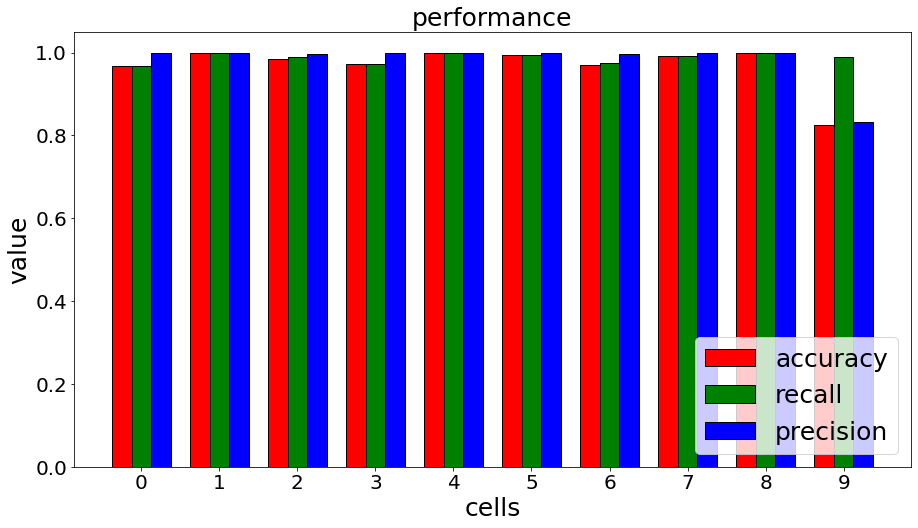

In [37]:
s = perf_IC60_t
n_cell = 10
r = np.arange(n_cell)
width = 0.25
plt.figure(figsize=(15,8))
plt.bar(r, s['accuracy'], color = 'r',
        width = width, edgecolor = 'black',
        label='accuracy')
plt.bar(r + width, s['recall'], color = 'g',
        width = width, edgecolor = 'black',
        label='recall')
plt.bar(r + 2*width, s['precision'], color = 'b',
        width = width, edgecolor = 'black',
        label= 'precision')

plt.xlabel("cells", fontsize = 25)
plt.ylabel("value", fontsize = 25)
plt.title("performance", fontsize = 25)

plt.xticks(r + width,[str(i) for i in range(n_cell)])
plt.legend(loc = "lower right", fontsize=25)
  
plt.show()